In [2]:
import pandas as pd
import numpy as np
import torch

In [3]:
default_aa_keys='-GALMFWKQESPVICYHRNDT'
def fasta_to_df(fasta_file, aa_keys = default_aa_keys):
    """
    creates one hot encoding of a fasta file using biopython's alignio.read process. 
    fasta_file : filepath leading to msa file in fasta format at hand
    """
    column_names = []
    column_names.extend(aa_keys)
    msa=AlignIO.read(fasta_file, "fasta")
    num_columns = len(msa[0].seq)
    column_names = column_names*num_columns
    column_names.append('sequence')
    column_names.append('id')
    init = np.zeros((len(msa), len(column_names)))
    df = pd.DataFrame(init, columns = column_names)
    df.sequence = df.sequence.astype(str)
    df.id=df.id.astype(str)
    
    for row_num, alignment in tqdm(enumerate(msa)):
        sequence = str(alignment.seq)
        for index, char in enumerate(sequence):
            place = aa_keys.find(char)
            df.iloc[row_num, index*len(aa_keys) + place] = 1
        
        df.iloc[row_num,-2]=str(alignment.seq)
        df.iloc[row_num,-1]=str(alignment.id)
    
    return df

In [4]:
def create_frequency_matrix(df, aa_keys = default_aa_keys):
    """takes one hot encoded msa and returns the frequency of each amino acid at each site
    df : pandas dataframe whose columns are the one hot encoding of an msa
    """
    num_columns=len(df['sequence'][0])
    
    frequency_matrix = np.zeros( (len(aa_keys) , num_columns) )
    print('calcing sum')
    freq=df.sum()
    print('sum calced')
    
    num_entries=len(df)
    len_aa_keys = len(aa_keys)
    
    for i in tqdm(range(len(aa_keys))):
        for j in range(num_columns):
            frequency_matrix[i, j] = freq[ i + len_aa_keys * j] / num_entries
    
    return frequency_matrix

In [5]:
msa = pd.read_csv('SH3_Full_Dataset_8_9_22.csv')
msa['Type'].unique()
naturals_msa = msa[msa['Type']=='Naturals']
seqs = np.asarray([list(seq) for seq in naturals_msa['Sequences']])
norm_re = np.asarray([re for re in naturals_msa['Norm_RE']])

In [6]:
from Bio import AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from tqdm import tqdm
vae_alignment = []
phenotypes = []

vae_data = msa[msa['Type']=='VAE'].reset_index()

for r in range(len(vae_data)):
    alignment = vae_data.loc[r]
    if len(alignment['Sequences'])==62:
        record = SeqRecord(seq = Seq(alignment['Sequences']), id = alignment['Header'])
    
    vae_alignment.append(record)
    phenotypes.append(alignment['Norm_RE'])

vae_alignment = AlignIO.MultipleSeqAlignment(vae_alignment)

AlignIO.write(vae_alignment, 'vae_alignment.fasta', 'fasta')

vae_df = fasta_to_df('vae_alignment.fasta')

freq_matrix = create_frequency_matrix(vae_df)

trim_positions = []

for i in range(freq_matrix.shape[1]):
    if 1 in freq_matrix[:,i]:
        trim_positions.append(i)

print(trim_positions)


vae_alignment_trimmed = []


for alignment in vae_alignment:
    new_seq = ''
    for i in range(62):
        if i not in trim_positions:
            new_seq+=alignment.seq[i]
    re_alignment = SeqRecord(seq=Seq(new_seq), id = alignment.id)
    vae_alignment_trimmed.append(re_alignment)

vae_alignment_trimmed = AlignIO.MultipleSeqAlignment(vae_alignment_trimmed)

AlignIO.write(vae_alignment_trimmed, 'vae_alignment_trimmed.fasta', 'fasta')

test_seqs = np.asarray([list(str(alignment.seq)) for alignment in vae_alignment_trimmed])

phenotypes = np.asarray(phenotypes)

11608it [01:58, 98.14it/s] 


calcing sum
sum calced


100%|████████████████████████████████████████| 21/21 [00:00<00:00, 12137.30it/s]

[16, 17, 44]


In [7]:
AMINO_ACIDS = "ARNDCQEGHILKMFPSTWYV-"
IDX_TO_AA = list(AMINO_ACIDS)
AA_TO_IDX = {aa: i for i, aa in enumerate(IDX_TO_AA)}

In [8]:
class ProteinDataset(torch.utils.data.Dataset):
    """
    takes in sequence data and phenotype data and spits back two dictionaries, X with one key - sequence, and Y with one, potentially two, keys - sequence and phenotype
    inputs:
        seq_data: np.array representing sequences
        phenotype_data np.array representing phenotypes
    
    """
    
    def __init__(self,
                 seq_data,
                 phenotype_data = None,
                **kwargs):
        super().__init__(**kwargs)
        self.seqs = seq_data
        self.phenotype_data = phenotype_data
        self.AMINO_ACIDS = "ARNDCQEGHILKMFPSTWYV-"
        self.IDX_TO_AA = list(self.AMINO_ACIDS)
        self.AA_TO_IDX = {aa: i for i, aa in enumerate(self.IDX_TO_AA)}

    def __len__(self):
        return self.seqs.shape[0]

    def __getitem__(self, index):
        X = dict()
        Y = dict()
        if self.phenotype_data is not None:
            Y['pheno'] = self.phenotype_data[index]

        one_hot_seq = self._to_one_hot(self.seqs[index])
        Y['seq'] = one_hot_seq
        X['seq'] = one_hot_seq
        return X, Y

    def _to_one_hot(self, seq):
        one_hot_encoded = np.zeros((seq.shape[0],len(self.IDX_TO_AA)))

        for index, char in enumerate(seq):
            one_hot_encoded[index, self.AA_TO_IDX[char]]=1
        return torch.tensor(one_hot_encoded, dtype=torch.float32)

In [9]:
class MLP(torch.nn.Module):
    """creates an MLP network, that starts with input of a given size, and then constructs a network with 
    hidden dimension of each layer being given by the values of the list output sizes
    """
    def __init__(self, 
        input_size,
        output_sizes,
        **kwargs
    ):
        super(MLP, self).__init__(**kwargs)
        self.input_size = input_size
        self.output_sizes = output_sizes
        
        self.mlp = torch.nn.Sequential()

        self.mlp.add_module('input_layer', torch.nn.Linear(input_size, output_sizes[0]))
        self.mlp.add_module('relu', torch.nn.LeakyReLU(0.2))
        #self.mlp.add_module('dropout', torch.nn.AlphaDropout(0.1))

        for index in range(1, len(output_sizes)):
            self.mlp.add_module('hidden_layer_{}'.format(index), torch.nn.Linear(output_sizes[index-1], output_sizes[index]))
            self.mlp.add_module('relu_{}'.format(index+1), torch.nn.LeakyReLU(0.2))
            #self.mlp.add_module('dropout_{}', torch.nn.AlphaDropout(0.1))


    def forward(self, x):
        assert x.shape[-1] == self.input_size, "Input to MLP not the correct dimension"

        return self.mlp(x)

In [10]:
#Building a VQ VAE

class VQ_VAE(torch.nn.Module):
    """VQ VAE. takes in an encoder and a decoder and can be used to train a VQ VAE, as defined in neural representations paper
    """

    def __init__(self,
                 encoder,
                 decoder,
                 latent_dim,
                 embeddings_per_dim,
                 **kwargs
                ):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.latent = torch.nn.Embedding(latent_dim, embeddings_per_dim)
        self.latent.weight.data.uniform_(-1./embeddings_per_dim, 1./embeddings_per_dim)
        self.embeddings_per_dim = embeddings_per_dim
        self.latent_dim = latent_dim
        self.LastDecoderLayer = torch.nn.Linear(1239,1239)


    def find_activated_embedding(self, Z_enc, embedding_weights):
        """
        compute pairwise distance between output of encoder and the embedding weight matrix, and return the activations of each embedding vector,
        and the corresponding index of the most important one.

        input:
            Z_enc: output of the encoder network (batch, embedding_dim)
            embedding_weights: the weights of the embedding layer (num_embedding vectors, embedding_dim)

        output:
            activations: activations of each embedding vector (batch, num_embedding_vectors)
            which_indices: which embedding vector was activated, by argmin. (batch, 1)

        """
        

        zsquared = torch.sum(Z_enc.pow(2), dim=1, keepdim=True)
        esquared = torch.sum(embedding_weights.pow(2), dim=1, keepdim=True)


        z_by_e = torch.matmul(Z_enc, embedding_weights.t())

        activations = (zsquared + esquared.t() - 2*z_by_e)
        which_indices = torch.argmin(activations, dim=1)

        return activations, which_indices

    def encode(self, x):
        x = x.view(x.shape[0], x.shape[1]*x.shape[2])
        z_enc = self.encoder(x)
        activations, which_indices = self.find_activated_embedding(z_enc, self.latent.weight)
        return activations, which_indices

    def decode(self, which_indices):
        z_q_enc = self.latent.weight[which_indices]
        xhat = self.decoder(z_q_enc)
        xhat = xhat.shape((xhat.shape[0], xhat.shape[1]/21, 21))
        return xhat

    def forward(self, x, y=None):
        """takes in a sequence, feeds it through an encoder and decoder cycle to produce a reconstructed sequence.
        Critically, it follows the straight through estimator of gradients, and provides the stop gradient losses
        as described in the paper

        input:
            x: seqs
            y: the target seqs, equal to x. When included, it returns the loss as the third argument

        output:
            xhat: the reconstructed sequence
            which_indices: the indices of the embedding vectors
            z_q: the embedding vectors used
            loss: optional, but sum of cross_entropy loss, embedding loss, and commitment loss
        """

        x = x.view(x.shape[0], x.shape[1]*x.shape[2])
        z_enc = self.encoder(x)
        activations, which_indices = self.find_activated_embedding(z_enc, self.latent.weight)
        one_hot_embeddings = torch.nn.functional.one_hot(which_indices, self.latent_dim)
        
        z_q = torch.matmul(one_hot_embeddings.float(), self.latent.weight)

        commitment_loss = self.commitment_loss(z_enc, z_q)
        embedding_opt_loss = self.embedding_opt_loss(z_enc, z_q)

        z_q = z_enc + (z_q - z_enc).detach()

        xhat = self.decoder(z_q)
        xhat = self.LastDecoderLayer(xhat)
        
        xhat = xhat.view(x.shape[0],x.shape[1]//21, 21)
        xhat = torch.nn.Softmax(dim=-1)(xhat)

        if y is not None:
            cross_entropy_loss = self.cross_ent_loss(xhat, y)
            return xhat, which_indices, z_q, cross_entropy_loss + embedding_opt_loss + commitment_loss

        else:
            return xhat, which_indices, z_q
            

    def cross_ent_loss(self, xhat, y):
        cross_entropy = torch.sum(- y * torch.log(xhat+1e-6) - (1-y)*torch.log(1-xhat+1e-6))
        return cross_entropy

    def commitment_loss(self, z_enc, z_q):
        commitment_loss = torch.sum((z_enc - z_q.detach())**2)
        return commitment_loss

    def embedding_opt_loss(self, z_enc, z_q):
        embedding_opt_loss = torch.sum((z_enc.detach() - z_q)**2)
        return embedding_opt_loss
        
    
        

In [43]:
encoder_input_size = seqs.shape[1]*len(AA_TO_IDX)
encoder_output_sizes = [128,128,128]

decoder_input_size = encoder_output_sizes[-1]
decoder_output_sizes = [128, 128, seqs.shape[1]*len(AA_TO_IDX)]

encoder = MLP(encoder_input_size, encoder_output_sizes)
decoder = MLP(decoder_input_size, decoder_output_sizes)

latent_dim = 100
embedding_dim = 128

vq_vae_example = VQ_VAE(encoder, decoder, latent_dim, embedding_dim)

In [44]:
vq_vae_example

VQ_VAE(
  (encoder): MLP(
    (mlp): Sequential(
      (input_layer): Linear(in_features=1239, out_features=128, bias=True)
      (relu): LeakyReLU(negative_slope=0.2)
      (hidden_layer_1): Linear(in_features=128, out_features=128, bias=True)
      (relu_2): LeakyReLU(negative_slope=0.2)
      (hidden_layer_2): Linear(in_features=128, out_features=128, bias=True)
      (relu_3): LeakyReLU(negative_slope=0.2)
    )
  )
  (decoder): MLP(
    (mlp): Sequential(
      (input_layer): Linear(in_features=128, out_features=128, bias=True)
      (relu): LeakyReLU(negative_slope=0.2)
      (hidden_layer_1): Linear(in_features=128, out_features=128, bias=True)
      (relu_2): LeakyReLU(negative_slope=0.2)
      (hidden_layer_2): Linear(in_features=128, out_features=1239, bias=True)
      (relu_3): LeakyReLU(negative_slope=0.2)
    )
  )
  (latent): Embedding(100, 128)
  (LastDecoderLayer): Linear(in_features=1239, out_features=1239, bias=True)
)

In [45]:
for parameter in vq_vae_example.parameters():
    print(parameter.shape)

torch.Size([128, 1239])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([1239, 128])
torch.Size([1239])
torch.Size([100, 128])
torch.Size([1239, 1239])
torch.Size([1239])


In [46]:
from tqdm import tqdm
from tensorboardX import SummaryWriter


EPOCHS=80
vq_vae_example.train()
optim = torch.optim.Adam(vq_vae_example.parameters(), lr = 1e-3)
writer = SummaryWriter()

proteins = ProteinDataset(seq_data=seqs, phenotype_data=None)
val_proteins = ProteinDataset(seq_data=test_seqs, phenotype_data=None)

global_step = 0


for epoch in range(EPOCHS):
    overall_loss = 0
    loader = torch.utils.data.DataLoader(dataset=proteins, batch_size=100, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_proteins, batch_size=test_seqs.shape[0], shuffle=False)
    for i, batch in enumerate(loader):
        
        global_step+=1
        X, Y = batch
        
        X_seqs = X['seq']
        
        Y_seqs = Y['seq']
        optim.zero_grad()
        x_hat, which_indices, z_q, loss = vq_vae_example(X_seqs, Y_seqs)

        overall_loss += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(vq_vae_example.parameters(),100)
        optim.step()
        writer.add_scalars('training_loss',{
                    'loss':loss,
                }, global_step)
    print('training loss at epoch {} is '.format(epoch) + str(overall_loss/seqs.shape[0]))
    for batch in val_loader:
        X, Y = batch
        
        X_seqs = X['seq']
        
        Y_seqs = Y['seq']
        optim.zero_grad()
        x_hat, which_indices, z_q, loss = vq_vae_example(X_seqs, Y_seqs)
        print('val loss at epoch {} is '.format(epoch) + str(loss.item()/(test_seqs.shape[0])))

    

training loss at epoch 0 is 184.64615533614113
val loss at epoch 0 is 161.81557977257063
training loss at epoch 1 is 171.36522791838843
val loss at epoch 1 is 159.0646967608546
training loss at epoch 2 is 168.273527892562
val loss at epoch 2 is 159.4746187973811
training loss at epoch 3 is 167.67618478822314
val loss at epoch 3 is 160.15502239834598
training loss at epoch 4 is 168.18909763886683
val loss at epoch 4 is 160.5456150930393
training loss at epoch 5 is 167.49022171010807
val loss at epoch 5 is 161.29969633011717
training loss at epoch 6 is 167.04964674884775
val loss at epoch 6 is 162.6871338731909
training loss at epoch 7 is 167.59977650190717
val loss at epoch 7 is 161.99655410062027
training loss at epoch 8 is 167.29594437877464
val loss at epoch 8 is 161.9224134217781
training loss at epoch 9 is 166.9797766509059
val loss at epoch 9 is 161.8891604927636
training loss at epoch 10 is 166.6914775210585
val loss at epoch 10 is 161.483416609235
training loss at epoch 11 is 16

In [47]:
val_proteins = ProteinDataset(seq_data=test_seqs, phenotype_data=None)
val_loader = torch.utils.data.DataLoader(dataset=val_proteins, batch_size=test_seqs.shape[0], shuffle = False)

for batch in val_loader:
    break

val_X, val_Y = batch

val_X_seqs = val_X['seq']
val_Y_seqs = val_Y['seq']

vq_vae_example.eval()

x_hat, which_indices, z_q, loss = vq_vae_example(val_X_seqs, val_Y_seqs)

#x_hat, which_indices, z_q, loss = vq_vae_example(val_X_seqs, val_Y_seqs)
accuracy = 0
total_count = 0
for seq_index in tqdm(range(val_X_seqs.shape[0])):
    for pos_index in  range(val_X_seqs.shape[1]):
        
        index_to_know = np.where(max(val_Y_seqs[seq_index][pos_index]) == val_Y_seqs[seq_index][pos_index])[0][0]
        index_guessed = np.where(max(x_hat[seq_index][pos_index]) == x_hat[seq_index][pos_index])[0][0]

        if index_guessed == index_to_know:
            accuracy+=1
        total_count+=1

100%|█████████████████████████████████████| 11608/11608 [02:01<00:00, 95.69it/s]


In [48]:
accuracy/total_count

0.5329798852924342

In [49]:
val_proteins = ProteinDataset(seq_data=seqs, phenotype_data=None)
val_loader = torch.utils.data.DataLoader(dataset=val_proteins, batch_size=seqs.shape[0], shuffle = False)

for batch in val_loader:
    break

val_X, val_Y = batch

val_X_seqs = val_X['seq']
val_Y_seqs = val_Y['seq']

vq_vae_example.eval()

x_hat, which_indices, z_q, loss = vq_vae_example(val_X_seqs, val_Y_seqs)

x_hat, which_indices, z_q, loss = vq_vae_example(val_X_seqs, val_Y_seqs)
accuracy = 0
total_count = 0
for seq_index in tqdm(range(val_X_seqs.shape[0])):
    for pos_index in  range(val_X_seqs.shape[1]):
        
        index_to_know = np.where(max(val_Y_seqs[seq_index][pos_index]) == val_Y_seqs[seq_index][pos_index])[0][0]
        index_guessed = np.where(max(x_hat[seq_index][pos_index]) == x_hat[seq_index][pos_index])[0][0]

        if index_guessed == index_to_know:
            accuracy+=1
        total_count+=1

100%|██████████████████████████████████████| 7865/7865 [01:16<00:00, 102.74it/s]


In [50]:
accuracy/total_count

0.531589212020645

In [51]:
val_proteins = ProteinDataset(seq_data=test_seqs, phenotype_data=None)
val_loader = torch.utils.data.DataLoader(dataset=val_proteins, batch_size=test_seqs.shape[0], shuffle = False)

for batch in val_loader:
    break

synthetic_val_X, synthetic_val_Y = batch

synthetic_val_X_seqs = synthetic_val_X['seq']
synthetic_val_Y_seqs = synthetic_val_Y['seq']

vq_vae_example.eval()

synthetic_x_hat, synthetic_which_indices, synthetic_z_q, synthetic_loss = vq_vae_example(synthetic_val_X_seqs, synthetic_val_Y_seqs)


Text(0, 0.5, 'Normalized Relative Enrichment')

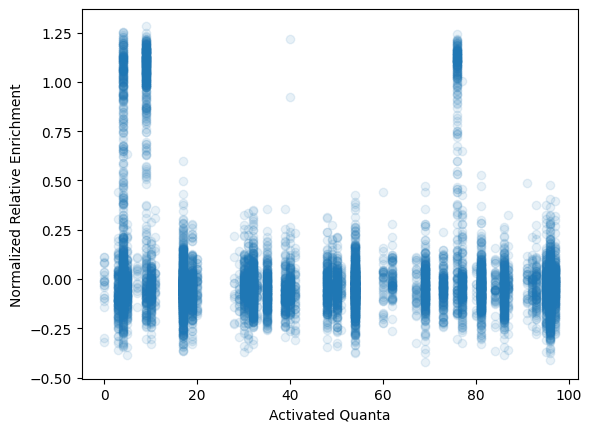

In [52]:
import matplotlib.pyplot as plt

plt.scatter(synthetic_which_indices.detach().numpy(), phenotypes, alpha=0.1)
plt.xlabel('Activated Quanta')
plt.ylabel('Normalized Relative Enrichment')

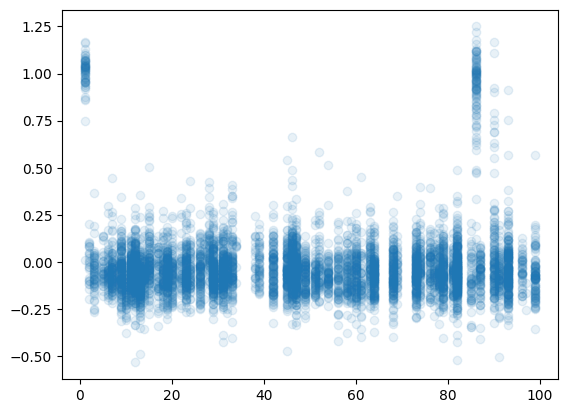

In [109]:
import matplotlib.pyplot as plt

plt.scatter(which_indices.detach().numpy(), norm_re, alpha=0.1)

In [63]:
active_seqs = test_seqs[phenotypes>0.8]

In [55]:
counts_of_occupancies = []

for index in range(100):
    counts_of_occupancies.append(which_indices[which_indices==index].shape[0])

(array([50.,  1.,  0.,  1.,  2.,  4.,  7.,  2.,  4.]),
 array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.]),
 <BarContainer object of 9 artists>)

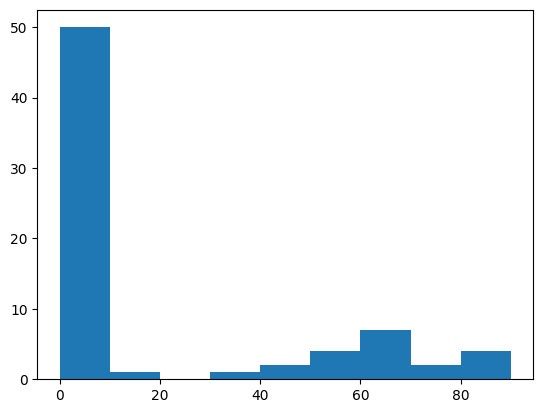

In [62]:
plt.hist(counts_of_occupancies, bins = np.arange(0,100,10))

In [64]:
active_seqs.shape

(663, 59)

In [65]:
active_proteins = ProteinDataset(seq_data=active_seqs, phenotype_data=None)
active_loader = torch.utils.data.DataLoader(dataset = active_proteins, batch_size = active_seqs.shape[0], shuffle=False)

In [66]:
for batch in active_loader:
    break

In [67]:
active_X, active_Y = batch

In [68]:
active_X_seqs = active_X['seq'] 
active_Y_seqs = active_Y['seq'] 


active_x_hat, active_which_indices, active_z_q, active_loss = vq_vae_example(active_X_seqs, active_Y_seqs)

In [69]:
np.unique(active_which_indices.detach().numpy())

array([ 4,  9, 40, 76, 77])

In [70]:
active_which_indices

tensor([40,  4,  4,  4,  4, 76, 76, 76, 76,  9, 76, 76, 76, 76, 76, 76, 76, 76,
        76, 76, 76,  4, 76,  4, 40,  9,  9,  9,  4, 76, 76,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  9, 76,  4, 76, 76, 76, 76,  4, 76, 76, 76, 76,  9,
        76, 76, 76, 76,  4, 76, 76, 76, 76, 76, 76,  9, 76, 76,  4, 76,  9, 76,
         4,  4,  4, 76, 76, 76, 76, 76, 76,  4, 76, 76, 76, 76, 76, 76, 76, 76,
        76,  9, 76, 76,  4,  4, 76, 76, 76, 76, 76,  9, 76, 76, 76, 76, 76, 76,
        76, 76,  9, 76, 76,  4, 76, 76,  4, 76, 76, 76, 76,  4,  9,  9,  4, 76,
         9,  4,  4,  4,  4,  4, 76, 76,  4,  9,  4,  4,  4,  4,  4,  9,  4,  9,
         4,  9,  9,  4,  4,  4,  9,  9,  4,  4,  9,  9,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  9,  9,  9,  9,  4,  4,  9, 76,
        76, 76, 76, 76,  4,  4,  4,  9,  4,  9,  9, 76, 76,  9,  4,  9,  4,  4,
         9,  9,  9,  9,  4,  4,  9,  9,  4,  4,  9,  4,  9,  4,  9,  9,  9,  9,
         9,  4,  9, 77, 76,  9,  9, 76, 

In [71]:
active_x_hat.detach().numpy()[1]

array([[1.0235093e-01, 1.4808435e-02, 1.3774602e-01, ..., 1.7661183e-03,
        2.9915730e-02, 2.0751096e-02],
       [5.8245290e-02, 3.3587132e-02, 3.0576633e-03, ..., 2.0313348e-01,
        6.0782123e-02, 2.5888735e-03],
       [5.8783796e-02, 1.2257477e-01, 2.6178570e-02, ..., 1.2418608e-03,
        1.1075234e-01, 1.9572710e-03],
       ...,
       [1.0799632e-02, 6.5379399e-03, 1.6117579e-03, ..., 1.7345747e-02,
        9.8690413e-02, 3.9535686e-02],
       [1.0756840e-02, 1.3106461e-02, 2.9305855e-02, ..., 5.5612641e-04,
        1.2056057e-02, 4.2088366e-01],
       [1.6069761e-02, 3.2442961e-02, 2.9436646e-02, ..., 2.5252975e-03,
        1.3964355e-03, 6.8624479e-01]], dtype=float32)

In [72]:
active_x_hat.detach().numpy()[2]

array([[1.0235095e-01, 1.4808435e-02, 1.3774602e-01, ..., 1.7661183e-03,
        2.9915724e-02, 2.0751096e-02],
       [5.8245279e-02, 3.3587113e-02, 3.0576622e-03, ..., 2.0313340e-01,
        6.0782108e-02, 2.5888716e-03],
       [5.8783781e-02, 1.2257473e-01, 2.6178567e-02, ..., 1.2418609e-03,
        1.1075232e-01, 1.9572722e-03],
       ...,
       [1.0799631e-02, 6.5379408e-03, 1.6117581e-03, ..., 1.7345749e-02,
        9.8690398e-02, 3.9535671e-02],
       [1.0756840e-02, 1.3106461e-02, 2.9305855e-02, ..., 5.5612641e-04,
        1.2056057e-02, 4.2088366e-01],
       [1.6069764e-02, 3.2442961e-02, 2.9436646e-02, ..., 2.5252975e-03,
        1.3964355e-03, 6.8624479e-01]], dtype=float32)

In [73]:
decoded_active_seqs = np.zeros(active_seqs.shape, dtype=str)

for probability_vector_index in range(active_x_hat.detach().numpy().shape[0]):
    probability_vector = active_x_hat.detach().numpy()[probability_vector_index]
    for pos_index in range(probability_vector.shape[0]):
        probability_dist = active_x_hat.detach().numpy()[probability_vector_index, pos_index]
        index_of_interest = np.where(max(probability_dist)==probability_dist)[0][0]
        decoded_active_seqs[probability_vector_index, pos_index] = IDX_TO_AA[index_of_interest]

In [74]:
decoded_active_seqs[0]

array(['P', 'P', 'L', 'G', 'V', 'A', 'K', 'A', 'L', 'Y', 'D', 'Y', 'E',
       'A', 'Q', 'T', 'E', 'D', 'E', 'L', 'S', 'F', 'K', 'E', 'G', 'D',
       'L', 'L', 'Y', 'V', 'L', 'D', 'K', 'S', 'D', 'D', 'W', 'W', 'K',
       'V', 'R', 'S', 'D', 'G', 'K', 'V', 'G', 'L', 'V', 'P', 'A', 'N',
       'Y', 'V', 'E', 'E', 'I', 'E', 'P'], dtype='<U1')

In [75]:
decoded_active_seqs[1]

array(['N', 'F', 'P', 'Y', 'R', 'A', 'K', 'A', 'L', 'Y', 'S', 'Y', 'T',
       'A', 'D', 'D', 'P', 'N', 'E', 'I', 'S', 'F', 'E', 'K', 'G', 'E',
       'I', 'L', 'E', 'V', 'L', 'D', 'K', 'S', 'G', 'K', 'W', 'W', 'Q',
       'A', 'R', 'K', 'D', 'G', 'E', 'T', 'G', 'I', 'A', 'P', 'S', 'N',
       'Y', 'L', 'Q', 'L', 'L', '-', '-'], dtype='<U1')

In [77]:
activated_indices = np.unique(active_which_indices.detach().numpy())

unique_decoded_active_seqs = [decoded_active_seqs[active_which_indices==activated_index][0] for activated_index in activated_indices]

In [78]:
np.savez('vqvae_seqs_2.npz', unique_decoded_active_seqs)

In [69]:
for seq in unique_decoded_active_seqs:
    print(''.join(seq))
    

--LEFARALYDFTADDPDELSFKKGEILEILDKDDNWWKARNDGRTGLVPSNYVEVIDR
EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--
EYSYKAKALYAYTADDPNEISFAKGEILDILDKQGKWWQARKDGTVGIAPSNYLQII--
PPLGKARALYDFEAQNEDELSLKEGDVLEVLEKDDGWWLVRNDGEEGLVPANYLEEL--
PPKKVVVALYDYEAQSPDELSFKKGDFLIVLDD-DDWWEARNTGERGLVPSNYVEIFSK


In [ ]:
x_hat, which_indices, z_q, loss = vq_vae_example(val_X_seqs, val_Y_seqs)
accuracy = 0
total_count = 0
for seq_index in tqdm(range(val_X_seqs.shape[0])):
    for pos_index in  range(val_X_seqs.shape[1]):
        
        index_to_know = np.where(max(val_Y_seqs[seq_index][pos_index]) == val_Y_seqs[seq_index][pos_index])[0][0]
        index_guessed = np.where(max(x_hat[seq_index][pos_index]) == x_hat[seq_index][pos_index])[0][0]

        if index_guessed == index_to_know:
            accuracy+=1
        total_count+=1

In [401]:
accuracy/total_count

0.43179601443773435

In [76]:
which_indices.shape

torch.Size([7865])

In [115]:
which_indices

tensor([15, 31, 68,  ..., 82, 54, 93])

In [117]:
X_seqs

tensor([[[0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0., 

In [141]:
hamming_dists = []
num_seqs = []
detached_indices = which_indices.detach().numpy()
for index_of_embeddings in range(100):
    quantized_seqs = seqs[detached_indices==index_of_embeddings]
    quantized_proteins = ProteinDataset(seq_data=quantized_seqs, phenotype_data=None)
    if quantized_seqs.shape[0]>0:
        quantized_loader = torch.utils.data.DataLoader(quantized_proteins, batch_size = quantized_seqs.shape[0], shuffle = False)
        for batch in quantized_loader:
            break
        X, Y = batch
        X_seq = X['seq']
        X_seq = X_seq.view(X_seq.shape[0],-1)
        X_seq_normed = torch.sum(X_seq, dim=1, keepdim=True)
        XXt = torch.matmul(X_seq, X_seq.t())
        X_seq_pairwise_dist = 59 - XXt
        hamming_dists.append(torch.mean(X_seq_pairwise_dist).numpy())
        num_seqs.append(quantized_seqs.shape[0])

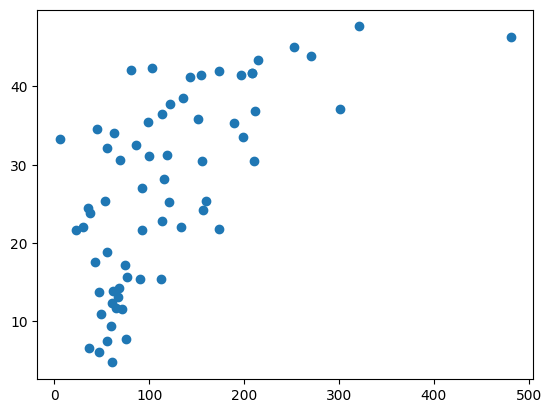

In [142]:
plt.scatter(num_seqs, hamming_dists)

In [162]:
quantized_seqs = seqs[detached_indices==82]
quantized_proteins = ProteinDataset(seq_data=quantized_seqs, phenotype_data=None)
if quantized_seqs.shape[0]>0:
    quantized_loader = torch.utils.data.DataLoader(quantized_proteins, batch_size = quantized_seqs.shape[0], shuffle = False)
    for batch in quantized_loader:
        break
    X, Y = batch
    X_seq = X['seq']
    X_seq = X_seq.view(X_seq.shape[0],-1)
    X_seq_normed = torch.sum(X_seq, dim=1, keepdim=True)
    XXt = torch.matmul(X_seq, X_seq.t())
    X_seq_pairwise_dist = 59 - XXt

In [163]:
quantized_seqs.shape

(481, 59)

In [165]:
quantized_seqs

array([['S', 'P', 'D', ..., 'I', 'D', 'K'],
       ['R', 'V', 'G', ..., '-', '-', '-'],
       ['F', 'A', 'Y', ..., 'T', 'V', 'R'],
       ...,
       ['P', 'Q', 'Q', ..., 'G', 'L', 'V'],
       ['D', 'H', 'V', ..., 'A', 'I', 'N'],
       ['R', 'Q', 'S', ..., 'V', 'G', 'K']], dtype='<U1')

In [168]:
which_indices.shape

torch.Size([7865])

In [79]:
np.savez('vq_embeddings.npz', seqs, which_indices)